<a href="https://colab.research.google.com/github/AmassABlue/AmassABlue/blob/main/TextMining_forDPFC_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 크롤링시 필요한 라이브러리 불러오기
from bs4 import BeautifulSoup
import requests
import re
import datetime
from tqdm import tqdm
import sys

# 페이지 url 형식에 맞게 바꾸어 주는 함수 만들기
  #입력된 수를 1, 11, 21, 31 ...만들어 주는 함수
def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num+1
    else:
        return num+9*(num-1)

#####뉴스크롤링 시작#####

#검색어 입력
search = input("검색할 키워드를 입력해주세요:")
#검색 시작할 페이지 입력
page = int(input("\n크롤링할 시작 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 시작 페이지: ",page,"페이지")   
#검색 종료할 페이지 입력
page2 = int(input("\n크롤링할 종료 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 종료 페이지: ",page2,"페이지") 
#검색 시작할 기간 입력
ds = input("\n크롤링 시작할 기간을 입력해주세요. ex)0000.00.00 : ") 
print("\n크롤링 시작 기간: ",ds)   
#검색 종료할 기간 입력
de = input("\n크롤링 종료할 기간을 입력해주세요. ex)0000.00.00 : ")
print("\n크롤링 종료 기간: ",de) 

# 크롤링할 url 생성하는 함수 만들기(검색어, 크롤링 시작 페이지, 크롤링 종료 페이지)

def makeUrl(search, start_pg, end_pg):
    if start_pg == end_pg:
        start_page = makePgNum(start_pg)
        url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&ds=" + ds +"&de=" + de + "&start=" + str(start_page)
        print("생성url: ", url)
        return url
    else:
        urls = []
        for i in range(start_pg, end_pg + 1):
            page = makePgNum(i)
            url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&ds=" + ds +"&de=" + de + "&start=" + str(page)
            urls.append(url)
        print("생성url: ", urls)
        return urls    

# html에서 원하는 속성 추출하는 함수 만들기 (기사, 추출하려는 속성값)
def news_attrs_crawler(articles,attrs):
    attrs_content=[]
    for i in articles:
        attrs_content.append(i.attrs[attrs])
    return attrs_content

# ConnectionError방지
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102"}

#html생성해서 기사크롤링하는 함수 만들기(url): 링크를 반환
def articles_crawler(url):
    #html 불러오기
    original_html = requests.get(i,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")

    url_naver = html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info")
    url = news_attrs_crawler(url_naver,'href')
    return url

# naver url 생성
url = makeUrl(search,page,page2)

#뉴스 크롤러 실행
news_titles = []
news_url =[]
news_contents =[]
news_dates = []
for i in url:
    url = articles_crawler(url)
    news_url.append(url)

#제목, 링크, 내용 1차원 리스트로 꺼내는 함수 생성
def makeList(newlist, content):
    for i in content:
        for j in i:
            newlist.append(j)
    return newlist

#제목, 링크, 내용 담을 리스트 생성
news_url_1 = []

#1차원 리스트로 만들기(내용 제외)
makeList(news_url_1,news_url)

#NAVER 뉴스만 남기기
final_urls = []
for i in tqdm(range(len(news_url_1))):
    if "news.naver.com" in news_url_1[i]:
        final_urls.append(news_url_1[i])
    else:
        pass

# 뉴스 내용 크롤링

for i in tqdm(final_urls):
    #각 기사 html get하기
    news = requests.get(i,headers=headers)
    news_html = BeautifulSoup(news.text,"html.parser")

    # 뉴스 제목 가져오기
    title = news_html.select_one("div.media_end_head.go_trans > div.media_end_head_title > h2")
    if title == None:
        title = news_html.select_one("#content > div.end_ct > div > h2")
    
    # 뉴스 본문 가져오기
    content = news_html.select("div#dic_area")
    if content == []:
        content = news_html.select("#articeBody")

    # 기사 텍스트만 가져오기
    # list합치기
    content = ''.join(str(content))

    # html태그제거 및 텍스트 다듬기
    pattern1 = '<[^>]*>'
    title = re.sub(pattern=pattern1, repl='', string=str(title))
    content = re.sub(pattern=pattern1, repl='', string=content)
    pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
    content = content.replace(pattern2, '')

    news_titles.append(title)
    news_contents.append(content)

    try:
        html_date = news_html.select_one("div.media_end_head.go_trans > div.media_end_head_info.nv_notrans > div.media_end_head_info_datestamp > div > span")
        news_date = html_date.attrs['data-date-time']
    except AttributeError:
        news_date = news_html.select_one("#content > div.end_ct > div > div.article_info > span > em")
        news_date = re.sub(pattern=pattern1,repl='',string=str(news_date))
    # 날짜 가져오기
    news_dates.append(news_date)

print("검색된 기사 갯수: 총 ",(page2+1-page)*10,'개')
print("\n[뉴스 제목]")
print(news_titles)
print("\n[뉴스 링크]")
print(final_urls)
print("\n[뉴스 내용]")
print(news_contents)

print('news_title: ',len(news_titles))
print('news_url: ',len(final_urls))
print('news_contents: ',len(news_contents))
print('news_dates: ',len(news_dates))

print(news_dates)

###데이터 프레임으로 만들기###
import pandas as pd

#데이터 프레임 만들기
news_df = pd.DataFrame({'date':news_dates,'title':news_titles,'link':final_urls,'content':news_contents})

#중복 행 지우기
news_df = news_df.drop_duplicates(keep='first',ignore_index=True)
print("중복 제거 후 행 개수: ",len(news_df))

#데이터 프레임 저장
now = datetime.datetime.now() 
news_df.to_csv('{}_{}.csv'.format(search,now.strftime('%Y%m%d_%H시%M분%S초')),encoding='utf-8-sig',index=False)

검색할 키워드를 입력해주세요:코로나

크롤링할 시작 페이지를 입력해주세요. ex)1(숫자만입력):1

크롤링할 시작 페이지:  1 페이지

크롤링할 종료 페이지를 입력해주세요. ex)1(숫자만입력):20

크롤링할 종료 페이지:  20 페이지

크롤링 시작할 기간을 입력해주세요. ex)0000.00.00 : 2023.01.01

크롤링 시작 기간:  2023.01.01

크롤링 종료할 기간을 입력해주세요. ex)0000.00.00 : 2023.01.24

크롤링 종료 기간:  2023.01.24
생성url:  ['https://search.naver.com/search.naver?where=news&sm=tab_pge&query=코로나&ds=2023.01.01&de=2023.01.24&start=1', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=코로나&ds=2023.01.01&de=2023.01.24&start=11', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=코로나&ds=2023.01.01&de=2023.01.24&start=21', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=코로나&ds=2023.01.01&de=2023.01.24&start=31', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=코로나&ds=2023.01.01&de=2023.01.24&start=41', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=코로나&ds=2023.01.01&de=2023.01.24&start=51', 'https://search.naver.com/search.naver?where=news&sm

100%|██████████| 172/172 [01:02<00:00,  2.73it/s]

검색된 기사 갯수: 총  200 개

[뉴스 제목]
['美 FDA “코로나19 백신, 연 1회 접종으로 바꿔야”', "'코로나 종식'보다 '금리인하' 우선…기업인 계묘년 희망뉴스", '코로나19 누적 확진자 3천만 명 넘어...세계 7번째', '코로나19 누적 확진자, 3000만명 넘어···전 세계 7번째', '코로나19 누적 확진자 3천만명 넘어…전 세계 7번째(종합)', '코로나 격리 거부하고 도주한 중국인 확진자, 처벌 없이 강제출국', "'코로나 도주' 중국인, 처벌 없이 중국행", '코로나 누적 확진 3천만명 넘어…전세계 7번째(종합)', '코로나 신규 확진 1만2262명…화요일 기준 30주 만에 최소', "\n\t\t\t'아바타2' 개봉 42일 만에 천만 돌파…코로나19 이후 외화 최초\n\t\t", "\n\t\t\t'아바타2' 개봉 42일 만에 천만 돌파…코로나19 이후 외화 최초\n\t\t", '코로나19 누적 확진 3천만 명 넘어…5명 중 3명 감염', '[속보]코로나 사망 10명, 99일만에 최소…위중증 468명', '중국 "13∼19일 코로나19 사망자 약 1만3천명"…축소 논란도', '중국 질병예방통제센터 전문가 "인구 약 80% 코로나19 감염"', "코로나로 멈췄던 450여 년 전통 '합동 세배' 재개", '경북, 574명 코로나19 확진…사망자는 1명', '설 연휴 셋째날 광주·전남 코로나19 확진 700명대', '귀경길 코로나19 검사', '코로나 누적 확진자 3000만명 넘어…세계 7번째', "바이든, 차기 백악관 비서실장에 '코로나 조정관' 자이언츠 검토", '북한, 코로나19 극복 다큐 방영…"80여일만 종식은 격동적 사변"', '“中 코로나 감염자 11억명”…전문가 첫 수치 제시', '대구교육청, 코로나19 교육결손 해소 지원 집중', "상하이 연등회 10만명 방문…中 '위드 코로나' 춘제 소비 들썩", '중국발 입국자 5명 코로나19 추가 확진…양성률 2.6%', '경남, 어제 898명 코로나 확진…사망 2명', '"코로나

In [ ]:
###텍스트 마이닝 시작###
csv_url = "/content/" + search + "_" + now.strftime('%Y%m%d_%H시%M분%S초') + ".csv"
# 기존에 있는 파일을 이용해서 하려면, 아래 주석을 이용
# csv_url = "/content/파일명.csv"

df = pd.read_csv(csv_url,index_col=0)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

import konlpy
from konlpy.tag import Okt

okt = Okt()

okt.nouns(df["content"].loc[0])

noun_list = []
for i in range(len(df)):
  noun_list.append(okt.nouns(df["content"].loc[i]))

total_word = []
for i in range(len(noun_list)):
  for j in range(len(noun_list[i])):
    total_word.append(noun_list[i][j])

len(total_word)

import collections
counter = collections.Counter(total_word)
counter.most_common(30)

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


[('명', 1728),
 ('코로나', 452),
 ('확', 406),
 ('진자', 402),
 ('것', 212),
 ('중국', 207),
 ('수', 192),
 ('누적', 192),
 ('감염', 156),
 ('지난', 153),
 ('등', 150),
 ('방역', 129),
 ('신규', 124),
 ('사망자', 118),
 ('발생', 108),
 ('이후', 104),
 ('기준', 103),
 ('국내', 102),
 ('중', 102),
 ('날', 99),
 ('지난해', 96),
 ('검사', 92),
 ('이', 88),
 ('전날', 88),
 ('기자', 85),
 ('환자', 84),
 ('전', 82),
 ('첫', 81),
 ('확진', 79),
 ('서울', 78)]

In [ ]:
! apt-get update -qq
! apt-get install fonts-nanum* -qq

# 폰트 설치(나눔 폰트)
import matplotlib.font_manager as fm 
sys_font = fm.findSystemFonts()

[f for f in sys_font if 'Nanum' in f]

In [ ]:
# 의미없는 단어의 수동 제거를 위한 기본 데이터 저장
temp = pd.DataFrame(counter.most_common(), columns=['word','count'])

# 최초의 데이터 csv로 저장
temp.to_csv('{}_{}.csv'.format("단어목록",now.strftime('%Y%m%d_%H시%M분%S초')),encoding='utf-8-sig',index=False)

In [ ]:
#--- 기존 데이터 있을 때 작동하지 말 것!! --- #
# 삭제한 데이터 프레임 목록을 저장하기 위해서, 데이터 프레임 csv 파일 생성
drop_data = pd.DataFrame(columns=['word','count'])
drop_data.to_csv('{}.csv'.format("삭제단어"),encoding='utf-8-sig',index=False)
#--- 기존 데이터 있을 때 작동하지 말 것!! --- #

In [ ]:
# 의미없는 단어의 삭제단어 저장 데이터에 의한 자동 제거
drop_data = pd.read_csv("/content/drive/MyDrive/Colab Data/삭제단어.csv")  # 삭제한 데이터 프레임 목록 불러오기

drop_criteria = 5  # 삭제단어 목록에서 일정 횟수 이상 조건 작성

for i in range(0,len(drop_data)):
  if drop_data.iat[i, 1] >= drop_criteria:
    idx = temp[temp['word'] == drop_data.iat[i, 0]].index

    if len(idx)!=0:
      temp.drop(idx, inplace=True)                # temp 자동삭제
      drop_data.loc[i, 'count'] += 1              # 삭제단어 데이터 증가
      print(drop_data.iat[i, 0], "삭제됨")

temp.to_csv('{}_{}.csv'.format("단어목록",now.strftime('%Y%m%d_%H시%M분%S초')),encoding='utf-8-sig',index=False)
drop_data.to_csv('{}.csv'.format("삭제단어"),encoding='utf-8-sig',index=False)

등 삭제됨
명 삭제됨
것 삭제됨
이 삭제됨
날 삭제됨
고 삭제됨
수 삭제됨
며 삭제됨
더 삭제됨
중 삭제됨
씨 삭제됨
위 삭제됨
및 삭제됨
그 삭제됨
또 삭제됨


In [ ]:
# 의미없는 단어의 수동 제거 반복문
print("'종료'라고 단어의 삭제를 끝마칩니다.")

while True:
  check = input("\n삭제할 단어 입력 : ")

  # 종료지점
  if check == "종료":
    break

  # 단어 검색
  idx = temp[temp['word'] == check].index
  if len(idx) == 0:
    print("존재하지 않는 단어입니다.")
  else:
    temp.drop(idx, inplace=True)
    print(check, "삭제")

    idx_drop_data = drop_data[drop_data['word'] == check].index
    if len(idx_drop_data) == 0:
      drop_data.loc[len(drop_data)] = [check,1]
    else:
      drop_data.loc[idx_drop_data, 'count'] += 1

  drop_data.to_csv('{}.csv'.format("삭제단어"),encoding='utf-8-sig',index=False)

'종료'라고 단어의 삭제를 끝마칩니다.

삭제할 단어 입력 : 전
전 삭제

삭제할 단어 입력 : 후
후 삭제

삭제할 단어 입력 : 를
를 삭제

삭제할 단어 입력 : 번
번 삭제

삭제할 단어 입력 : 로
로 삭제

삭제할 단어 입력 : 세
세 삭제

삭제할 단어 입력 : 소
소 삭제

삭제할 단어 입력 : 말
말 삭제

삭제할 단어 입력 : 중
존재하지 않는 단어입니다.

삭제할 단어 입력 : 뒤
뒤 삭제

삭제할 단어 입력 : 개
개 삭제

삭제할 단어 입력 : 의
의 삭제

삭제할 단어 입력 : 주
주 삭제

삭제할 단어 입력 : 종료


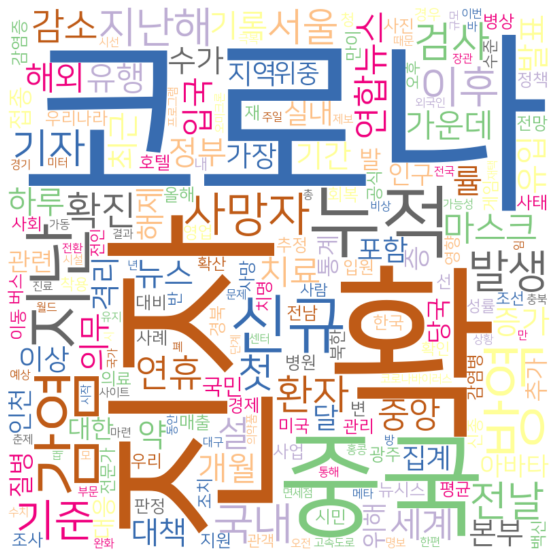

In [ ]:
# 텍스트 마이닝 그림으로 출력

from wordcloud import WordCloud
import matplotlib.pyplot as plt

words = dict(temp.set_index('word').T.to_dict('records')[0])

wordcloud = WordCloud(
    font_path = '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
    background_color='white',                             # 배경 색깔 정하기
    colormap = 'Accent_r',                                # 폰트 색깔 정하기
    width = 800,
    height = 800
)

wordcloud_words = wordcloud.generate_from_frequencies(words)

array = wordcloud_words.to_array()

fig = plt.figure(figsize=(10, 10))
plt.imshow(array, interpolation="bilinear")
plt.axis('off')
plt.show()